# I&E Study 7.1 Automated Stakeholder Analysis for Hedera


In this Notebook we will demonstrate how to scrape, clean, analyse and visualise data from different resources to do stakeholder analysis for Hedera.

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk

nltk.download("punkt")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import math
from langdetect import detect
from nltk import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Scraping

First we will gather data from the website https://seepnetwork.org. More specifically we will collect the data of the members of the seepnetwork.

For this we will define a method that will download the data, or if we already have the file in our local folder we just load it from there to reduce network traffic towards there website.

In [ ]:
import requests
import os
from pathlib import Path
from bs4.element import Comment

def load_page(name, path):
    
    displayname = name.replace('https://', '').replace('http://', '').replace('/', '')
    full_path = path+displayname
    
    content = ""
    
    try:
        with open(full_path, 'r', encoding='utf-8') as f:
            content = f.read().replace("\n", "").replace("\t", "")
    except (OSError, IOError) as e:
        url = name
        if "http" not in url:
            url = "http://" + url
        print("parsing: " + url)
        response = requests.get(url)
        directory = os.path.dirname(full_path)
        Path(directory).mkdir(parents=True, exist_ok=True)
        open(full_path, 'wb').write(response.content)
        content = response.content
        
    return content 

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

First we will scrape the main page.

In [ ]:
file_dir = "webpages/"
parent_page = "https://seepnetwork.org"
main_content = load_page(parent_page + "/Profiles", file_dir)

Next we will get all of the links to the individual member profile pages. Therefor we select all of the elements and extract the href field.

In [ ]:
from bs4 import BeautifulSoup

bs = BeautifulSoup(main_content)

sub_links = []
for link in bs.select(".mapListViewItem .button.border.blue a"):
    sub_links.append(link["href"])
    
print(f'We found {len(sub_links)} members.')

To get the members data we download the profile pages and parse the needed fields into an array for further processing.

In [ ]:
data = []

for link in sub_links:
    content = load_page(parent_page+link, file_dir)
    bs = BeautifulSoup(content)
    parts = bs.select(".sidebar.left")
    
    name = parts[0].select_one("h3").string.strip()
#   years_of_membership = parts[0].select_one(".sidebarRight > p").string[0]
    location = parts[0].select_one(".sidebarRight .twoColLeft > p").contents[-1].strip()
    website = parts[0].select_one(".sidebarRight .twoColRight a")['href'].strip()
    org_type = parts[0].select_one(".sidebarRight .twoColRight > p").contents[-1].strip()
    mission_statement = parts[1].select(".sidebarRight > p")[0].contents[-1].strip()
    countries_of_involvement = parts[1].select(".sidebarRight > p")[1].contents[-1].strip()
    practice_areas = parts[1].select(".sidebarRight > p")[2].contents[-1].strip()
    website_content = ""
    error_loading_website = False
    try:
        website_html = load_page(website, file_dir)
        if len(website_html) > 7232460:
            raise Exception("Website to large")
        texts = BeautifulSoup(website_html).findAll(text=True)
        visible_texts = filter(tag_visible, texts)  
        website_content = u" ".join(t.strip() for t in visible_texts)
    except Exception as err:
        error_loading_website = True
        print("unable to parse website content: " + website, err)
    data.append([name, location, website, org_type, mission_statement, countries_of_involvement, practice_areas, website_content, error_loading_website])

In [ ]:
# One Example
data[3]

Finally we write the parsed information into a csv file which can later be used as an input for the machine learning algorithms.

In [ ]:
import csv
wtr = csv.writer(open ('member_data.csv', 'w', encoding='utf-8'), delimiter=',', lineterminator='\n')
for member in data :
    wtr.writerow (member)
    
wtr = csv.writer(open ('member_data_without_website.csv', 'w', encoding='utf-8'), delimiter=',', lineterminator='\n')
for member in data :
    wtr.writerow (member[:-2])


## Analyzing the data


### Load Data in Pandas DataFrame 

First of all we load all data into a pandas data frame. 

In [2]:
df = pd.read_csv(
    "member_data.csv",
    header=None,
    names=[
        "name",
        "location",
        "website",
        "org_type",
        "mission_statement",
        "countries_of_involvement",
        "practice_areas",
        "website_content",
        "error_loading_website"
    ],
)

In [3]:
from google_trans_new import google_translator

translator = google_translator()

all_stopwords = stopwords.words("english")
all_stopwords.extend(
    [
        "twitter",
        "linkedin",
        "work",
        "youtube",
        "facebook",
        "about",
        "s",
        "site",
        "news"
    ]
)

def translate(text):
    lang = detect(text)
    if lang != "en":
        sent_token = sent_tokenize(text)
        translatedText = [
            translator.translate(sent, lang_tgt="en") for sent in sent_token
        ]
        text = (" ").join(translatedText)
        return text
    return text


def delete_stop_words(text, error=False):
    if not error:
        text = translate(text)

        text_tokens = word_tokenize(text)

        tokens_without_sw = [
            word.strip().lower()
            for word in text_tokens
            if not word.strip().lower() in all_stopwords
        ]
        return (" ").join(tokens_without_sw)
    else:
        # clean website_content
        return ""

def translate_text(text, error=False):
    if not error:
        return translate(text)        
    else:
        # clean website_content
        return ""

filter_content = [
    "403 forbidden nginx",
    "http://courtesy.amen.pt/index.html?pType=expired ",
    "The website is under construction",
]

df["error_loading_website"] = np.where(
    df["website_content"].str.contains(r"403|forbidden|expired|under construction|down for maintainance", na=True), True, df["error_loading_website"]
)

df["website_content"] = df.apply(
    lambda member: delete_stop_words(
        member.website_content, member.error_loading_website
    ),
    axis=1,
)
df["mission_statement"] = df.apply(
    lambda member: delete_stop_words(
        member.mission_statement
    ),
    axis=1,
)

df.to_csv("clean_translate_data.csv")

For each organisation with have name, location, website link, organization type, their mission statement, countries of involvement, practice areas.

In [ ]:
from pandas_profiling import ProfileReport

df_selected = df.loc[:, ["name", "org_type", "countries_of_involvement", "location", ]]
profile = ProfileReport(
    df,
    title="Pandas Profiling Report",
    correlations=None,
    samples=None,
    missing_diagrams=None,
    duplicates=None,
)
profile.to_notebook_iframe()

### Most Common Practice Areas

Each of the members is assigned to several practice areas. We take a look at which practice areas are most common among the members.

In [ ]:
# Practice area dict
practice_areas = {}

# Add practice areas to dictionary
def count_areas(areas):
    for area in areas:
        if area in practice_areas:
            practice_areas[area] += 1
        else:
            practice_areas[area] = 1  

In [ ]:
import numpy as np
import operator
# Load the regular expression library
import re

# Convert practice areas string to list of areas
df["practice_areas"] = df["practice_areas"].replace(np.nan, '', regex=True)
df["practice_areas"] =  df.apply(lambda x: re.sub(r'\([^)]*\)', '',x["practice_areas"]), axis=1)
df["practice_areas"] = df.apply(lambda x: [area.strip() for area in re.split('; |,',x["practice_areas"])], axis=1)
df.apply(lambda x: count_areas(x["practice_areas"]), axis=1)

# Print 10 most commom practice areas
most_common_pratice_areas = dict(sorted(practice_areas.items(), key=operator.itemgetter(1), reverse=True)[:10])

In [ ]:
most_common_pratice_areas

In [ ]:
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Pratice Areas')
plt.bar(most_common_pratice_areas.keys(), most_common_pratice_areas.values(), color='b')

### Mission Statement Modeling

We use regular expression for cleaning the mission statement and the website content. We delete all non word characters and replace all uppercase letters with lowercase letters, and lemmatize text(only keep adj, adv, noun, verb)

In [4]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wnl = WordNetLemmatizer()

# Remove punctuation
df["mission_statement_processed"] = df["mission_statement"].map(
    lambda x: re.sub("[,\.!?]", "", str(x))
)
df["website_content_processed"] = df["website_content"].map(
    lambda x: re.sub("[,\.!?]", "", str(x))
)
# Convert the tex to lowercase
df["mission_statement_processed"] = df["mission_statement_processed"].map(lambda x: x.lower())
df["website_content_processed"] = df["website_content_processed"].map(lambda x: x.lower())
df["processed_text"] = df["mission_statement_processed"] + df["website_content_processed"]
# Removing numbers
df["processed_text"] = df["processed_text"].str.replace('\d+', '')
df["lemmatized_text"] = df["processed_text"].map(lambda x: wnl.lemmatize(x))

df.to_csv("processed_data.csv")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
df[["mission_statement", "mission_statement_processed", "website_content", "website_content_processed", "processed_text", "lemmatized_text"]][5:10]

,mission_statement,mission_statement_processed,website_content,website_content_processed,processed_text,lemmatized_text
5,champion aspirations microfinance institutions...,champion aspirations microfinance institutions...,,,champion aspirations microfinance institutions...,champion aspirations microfinance institutions...
6,"promote professional , inclusive responsive mi...",promote professional inclusive responsive mic...,"plot 679 wamala road , amfiu house , najjanank...",plot 679 wamala road amfiu house najjanankum...,promote professional inclusive responsive mic...,promote professional inclusive responsive mic...
7,mission amir offer diversified services microf...,mission amir offer diversified services microf...,,,mission amir offer diversified services microf...,mission amir offer diversified services microf...
8,promote financial inclusion access financial s...,promote financial inclusion access financial s...,professional association microfinance institut...,professional association microfinance institut...,promote financial inclusion access financial s...,promote financial inclusion access financial s...
9,professional association decentralized financi...,professional association decentralized financi...,home presentation history mission vision objec...,home presentation history mission vision objec...,professional association decentralized financi...,professional association decentralized financi...


We also used the CountVectorizer from sklearn to plot the 10 most common words in the mission statements.

In [3]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# data = df["processed_text"].values.tolist()

# # Build the bigram and trigram models
# bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.

# # Faster way to get a sentence clubbed as a trigram/bigram
# bigram_mod = gensim.models.phrases.Phraser(bigram)

# # Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

In [14]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in all_stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = " ".join(sent)
        texts_out.append(wnl.lemmatize(doc))
    return texts_out


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv(
    "processed_data.csv", index_col=0)
df.head()

,name,location,website,org_type,mission_statement,countries_of_involvement,practice_areas,website_content,error_loading_website,mission_statement_processed,website_content_processed,processed_text,lemmatized_text
0,Access to Finance Rwanda,Rwanda,http://www.afr.rw/,Development Organization,"low income rwandans , especially women youth ,...",Rwanda,"Fragile & Conflict-affected Environments, Gend...",search linkedin-in facebook-f us history team ...,False,low income rwandans especially women youth b...,search linkedin-in facebook-f us history team ...,low income rwandans especially women youth b...,low income rwandans especially women youth b...
1,AEMFI - Association of Ethiopian Microfinance ...,Ethiopia,http://www.aemfi-ethiopia.org/,"National, Regional, Global Network",enhance capacity microfinance institutions fin...,Ethiopia,Education; Environment & Climate; Financial Co...,NaN,True,enhance capacity microfinance institutions fin...,NaN,enhance capacity microfinance institutions fin...,enhance capacity microfinance institutions fin...
2,Aga Khan Foundation USA,United States,https://www.akfusa.org/,Development Organization,"promote social development , primarily low inc...",Afghanistan; Bangladesh; India; Kenya; Kyrgyzs...,Education; Financial Consumer Protection; Food...,NaN,True,promote social development primarily low inco...,NaN,promote social development primarily low inco...,promote social development primarily low inco...
3,AMA - Afghanistan Microfinance Association,Afghanistan,http://www.ama.org.af/,"National, Regional, Global Network","build inclusive , sustainable responsible deve...",Afghanistan,Financial Inclusion,NaN,True,build inclusive sustainable responsible devel...,NaN,build inclusive sustainable responsible devel...,build inclusive sustainable responsible devel...
4,AMFA - Azerbaijan Micro-Finance Association,Azerbaijan,http://www.amfa.az/,"National, Regional, Global Network",strengthen capacity micro-finance institutions...,Azerbaijan,Financial Consumer Protection; Financial Inclu...,NaN,True,strengthen capacity micro-finance institutions...,NaN,strengthen capacity micro-finance institutions...,strengthen capacity micro-finance institutions...


#### Word Cloud

To determine the most common words in the mission statements, we created a Wordcloud. 

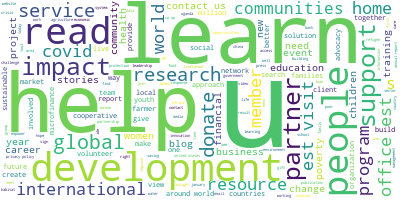

In [4]:
# Import the wordcloud library
from wordcloud import WordCloud
# Convert to list

# Join the different processed text together.
long_string = ','.join(list(df["lemmatized_text"].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### 10 Most Common Features

In [5]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))  
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    print(total_counts)
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    # print(words)
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

[ 1.  2. 14. ...  1.  1.  1.]


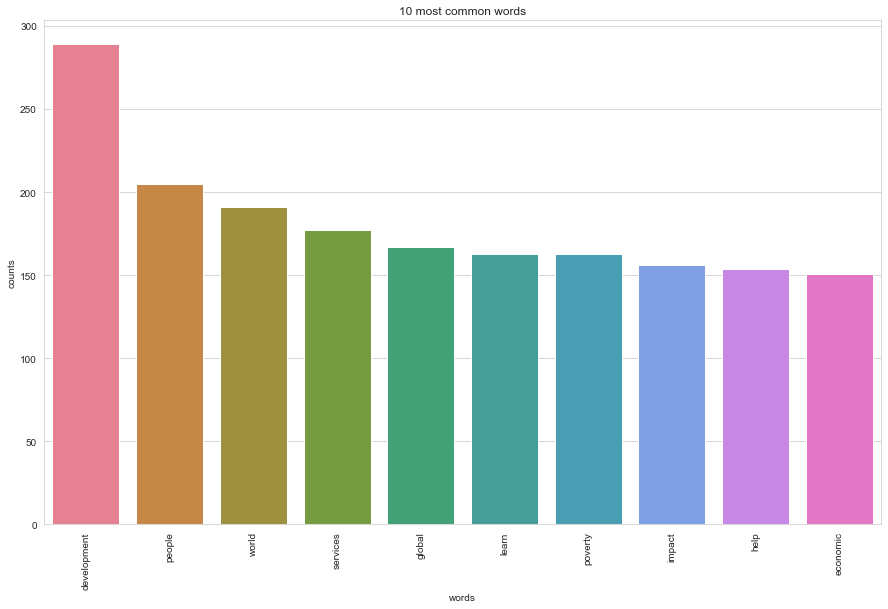

In [6]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words="english")
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df["lemmatized_text"])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

#### LDA

In order to get an even better understanding of the members mission, we use the Latent Dirichlet allocation algorithm. This method groups words into topics and rank the words according to their probability.

We set the number of topics to 5 and want to get the 10 most common words in those topics. 

In [7]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [8]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx+1:d}:")
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [9]:
def lda_models(number_topics, count_data):
    # Create and fit the LDA model
    model_list = []
    model_perplexity = []
    for num in number_topics:
        lda = LDA(n_components=num, max_iter=100, random_state=100, n_jobs=-1)
        lda.fit(count_data)
        model_list.append(lda)
        model_perplexity.append(lda.perplexity(count_data))

    return model_list, model_perplexity

We try LDA model with diferent number of topics, and evaluate the LDA models with Perplexity. A model with  lower perplexity is preferred. According to the graph, 8, 9, 10 would be good number of topics.

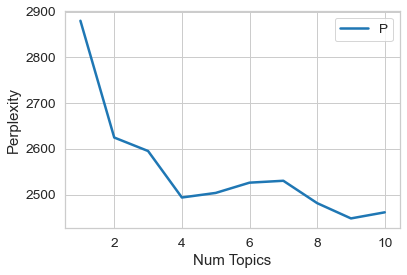

In [10]:
lda_models, lda_perplexity = lda_models(range(1,11), count_data)
plt.plot(range(1,11), lda_perplexity)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("Perplexity"), loc='best')
plt.show()

In [11]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_models[8], count_vectorizer, 10)

Topics found via LDA:

Topic #1:
global read people donate international women help habitat covid support

Topic #2:
cooperative op impact clusa read people development cordaid economic ncba

Topic #3:
research icrw development policy gender idrc hasal knowledge women finance

Topic #4:
new china ministry people united states water defense cases confirmed

Topic #5:
economic services development nathan program financial oxfam finance sector international

Topic #6:
ide research rti development data market health center global training

Topic #7:
poverty hope world help learn donate children yemen stories development

Topic #8:
business enterprise village partners development chemonics impact blog overview school

Topic #9:
microfinance office visit est financial members development institutions services association


#### PyLDAvis

We also tried a Python library for interactive topic model visualization called pyLDAvis.

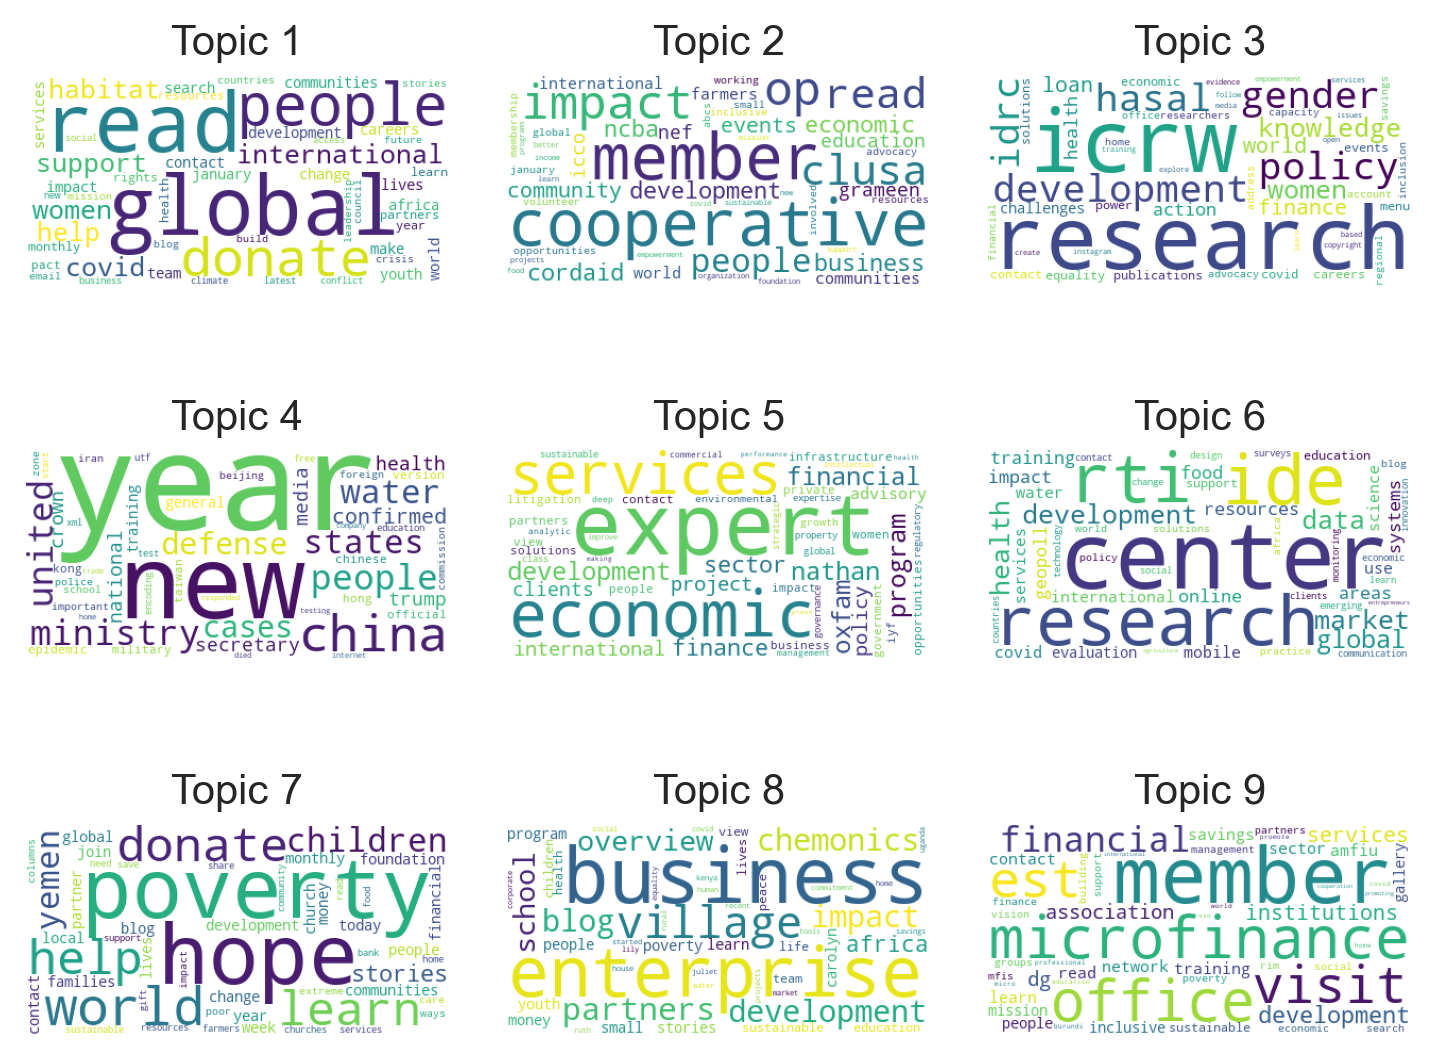

In [12]:
best_lda = lda_models[8]
topic_words = []
words = count_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(best_lda.components_):
     topic_words.append(" ".join([words[i]
                        for i in topic.argsort()[:-50 - 1:-1]]))

fig, axes = plt.subplots(3, 3, figsize=(6, 5), sharex=True, sharey=True, dpi=250)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
#     topic_words = dict(topics[i][1])
#     cloud.generate_from_frequencies(topic_words, max_font_size=300)    
    wordcloud.generate(topic_words[i])
    # Visualize the word cloud
#     wordcloud.to_image()
    plt.gca().imshow(wordcloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=12))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [13]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
# LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
LDAvis_prepared = sklearn_lda.prepare(best_lda, count_data, count_vectorizer)

Wall time: 2.71 s


In [15]:
pyLDAvis.enable_notebook()
pyLDAvis.show(LDAvis_prepared)
# from IPython.core.display import HTML

# viz = pyLDAvis.display(LDAvis_prepared)
# HTML(viz)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [07/Feb/2021 04:38:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Feb/2021 04:38:20] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Feb/2021 04:38:20] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Feb/2021 04:38:20] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


## LDA Mallet

Then we tried LDA mallet. Mallet uses Gibbs Sampling which is more precise than Gensim's faster and online Variational Bayes. 

In [11]:
# Create Dictionary
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# data = df["processed_text"].values.tolist()
texts = list(sent_to_words(df["lemmatized_text"]))
id2word = corpora.Dictionary(texts)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

pprint(ldamallet.show_topics(formatted=False))
gensim perplexity should also be high for a good model, -7.88 is better than -7.96. 

In [28]:
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=100, gamma_threshold=0.001, random_state=100, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [16]:
import os
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ['MALLET_HOME'] = 'F:\\TUB\\IE\\I-E7.1\\mallet-2.0.8'
mallet_path = 'F:\\TUB\\IE\\I-E7.1\\mallet-2.0.8\\bin\\mallet'

In [21]:
import gensim
def compute_coherence_values(dictionary, corpus, texts, canditates):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in canditates:
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, iterations=100, random_seed=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


There are many other approaches to evaluate Topic models such as Perplexity, but its poor indicator of the quality of the topics. Topic Coherence measure is a good way to compare difference topic models based on their human-interpretability. Coherence measures the relative distance between words within a topic. According to the graph, 6 or 8 would be good numbers to choose from since their coherence scores are the highest. And together with the perplexity value, 8 would be the best choice.

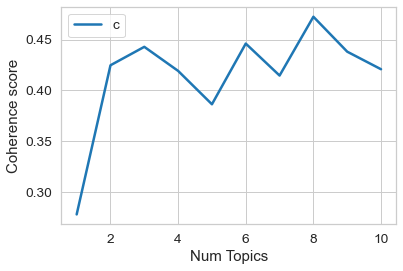

In [18]:
# Can take a long time to run.
x = range(1, 11)
models, coherence_value = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, canditates=x)
plt.plot(x, coherence_value)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
for idx, topic in models[7].print_topics(num_words=10):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.022*"give" + 0.020*"covid" + 0.017*"people" + 0.016*"stories" + 0.013*"contact" + 0.012*"women" + 0.012*"ways" + 0.011*"care" + 0.011*"reports" + 0.010*"poverty"
Topic: 1 
Words: 0.012*"united" + 0.012*"china" + 0.012*"states" + 0.010*"ministry" + 0.010*"people" + 0.008*"post" + 0.008*"national" + 0.008*"icrw" + 0.006*"bright" + 0.006*"secretary"
Topic: 2 
Words: 0.036*"services" + 0.035*"economic" + 0.018*"international" + 0.016*"finance" + 0.015*"financial" + 0.013*"market" + 0.011*"sector" + 0.011*"management" + 0.010*"ide" + 0.009*"clients"
Topic: 3 
Words: 0.032*"microfinance" + 0.021*"development" + 0.017*"foundation" + 0.017*"financial" + 0.017*"yemen" + 0.015*"money" + 0.015*"business" + 0.014*"members" + 0.013*"home" + 0.012*"partners"
Topic: 4 
Words: 0.029*"donate" + 0.029*"world" + 0.026*"poverty" + 0.022*"learn" + 0.021*"hope" + 0.020*"children" + 0.013*"families" + 0.012*"communities" + 0.012*"monthly" + 0.011*"local"
Topic: 5 
Words: 0.041*"development

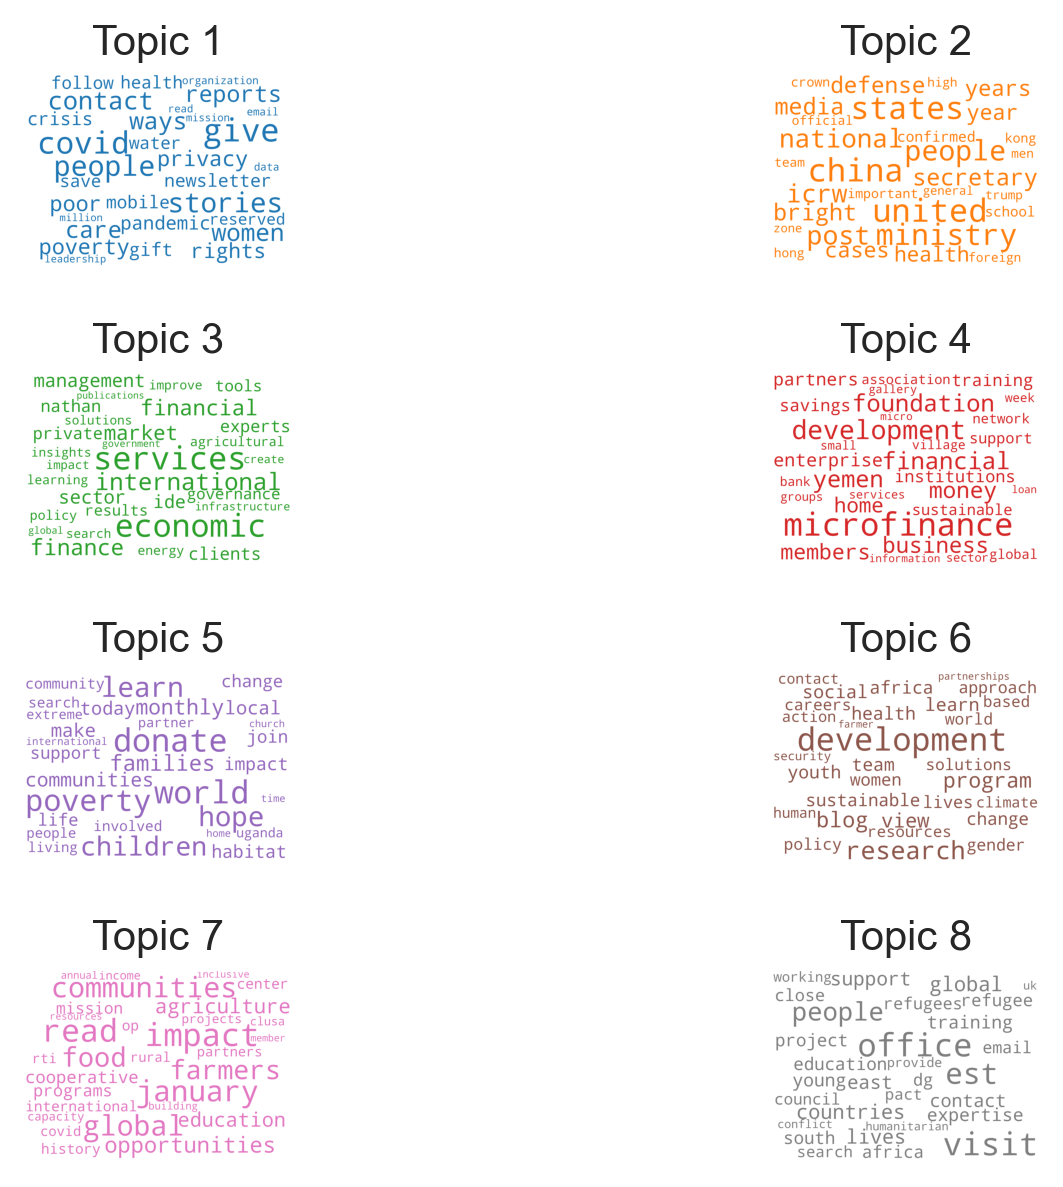

In [20]:
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = models[7].show_topics(num_topics=8, num_words=30, formatted=False)
fig, axes = plt.subplots(4, 2, figsize=(8, 5), sharex=True, sharey=True, dpi=250)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=12))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()